# Differential Phase Contrast Processing

In [2]:
import sys
import scipy.io as sio
import scipy.linalg as la
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio

from libwallerlab.utilities import iotools
from libwallerlab.utilities import displaytools
from libwallerlab.utilities import opticstools

from libwallerlab.opticsalgorithms import dpc
from libwallerlab.opticsalgorithms import fpm

%load_ext autoreload
%autoreload 2
%matplotlib notebook

c:\users\zack\anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


## Load Data

In [26]:
source_list_mat_file_name = './source_list_quasi_dome.mat'
# dataset_path = 'D:/Zack/2017-11-15-DPC-FPM/multi_contrast_2017_11_15_09_11_44/'
# dataset_path = 'D:/Zack/2017-11-15-DPC-FPM/multi_contrast_2017_11_15_10_05_26/'
# dataset_path = 'D:/Zack/2017-11-15-DPC-FPM/hek_multi_contrast_2017_11_15_10_30_27/'
# dataset_path = 'D:/Zack/2017-11-15-DPC-FPM/u2os_multi_contrast_2017_11_15_10_46_25/'
# dataset_path = 'D:/Zack/2017-11-17-DPC-FPM/_multi_contrast_2017_11_17_11_20_42/'
# dataset_path = 'D:/Zack/2017-11-17-DPC-FPM/_multi_contrast_2017_11_17_11_25_46/'
# dataset_path = 'D:/Zack/2017-11-17-DPC-FPM/_multi_contrast_2017_11_17_11_35_17'
# dataset_path= 'D:/Zack/2017-11-17-DPC-FPM/_multi_contrast_2017_11_17_11_42_16'
dataset_path = 'D:/Zack/2017-11-17-DPC-FPM/_multi_contrast_2017_11_17_12_09_10/'

dpc_dataset = iotools.Dataset(dataset_path=dataset_path)
dpc_dataset.subtractBackground()
# mat = sio.loadmat(source_list_mat_file_name)

# # Compute "designed" positions
# source_list_cart = mat['source_list_cart'].copy()
# max_z = np.max(source_list_cart[:,2])
# desired_z = 60    #TODO this
# source_list_cart[:, 2] = (source_list_cart[:, 2] - max_z) + desired_z
# dpc_dataset.metadata.illumination.state_list.design = iotools.cartToNa(source_list_cart)

# # Set calibrated positions
# dpc_dataset.metadata.illumination.state_list.calibrated = mat['source_list_na'].copy()

# # Set board indicies
# dpc_dataset.metadata.illumination.state_list.grouping = np.squeeze(np.asarray(mat['source_list_board_indicies']))

# # Set wavelength
dpc_dataset.metadata.illumination.spectrum.center = {"r" : 0.63, "g" : 0.53, "b": 0.48}

# dpc_dataset.subtractBackground(new_roi=False, plot_bg=False, max_thresh=500.)

dpc_dataset.applyNaTransformation(flip_xy=True)



None
{'center': {'r': 0.63, 'g': 0.53, 'b': 0.48}, 'full': None, 'units': 'um'}
Loaded dataset: _multi_contrast_2017_11_17_12_09_10
Using threshold: 1000.00
Finished subtracting background


# Perform Reconstruction

<IPython.core.display.Javascript object>


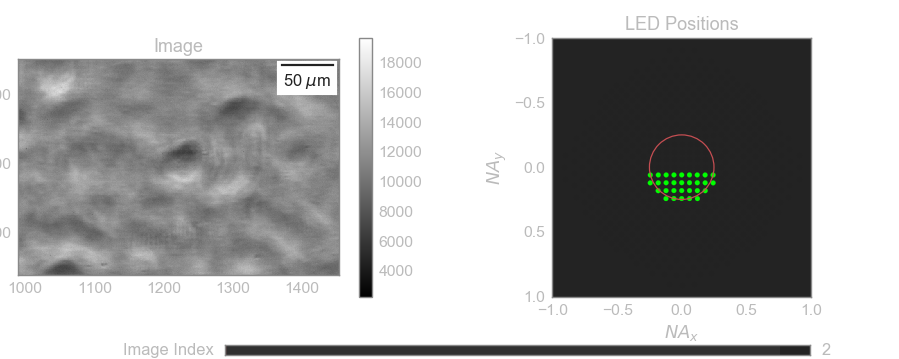

c:\users\zack\anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [25]:
dpc_dataset.show()

Could not find pre-calibrated positions - using design positions.
Initialized dataset: _multi_contrast_2017_11_17_12_09_10
    Using 4 of 4 images in dataset with size (512, 512)
    Imaging NA is 0.25 (1.92um min. feature size), Nyquist NA is 0.37 
    Illumination NA is 0.27, reconstructed NA is 0.52 (0.92um min feature size)


<IPython.core.display.Javascript object>


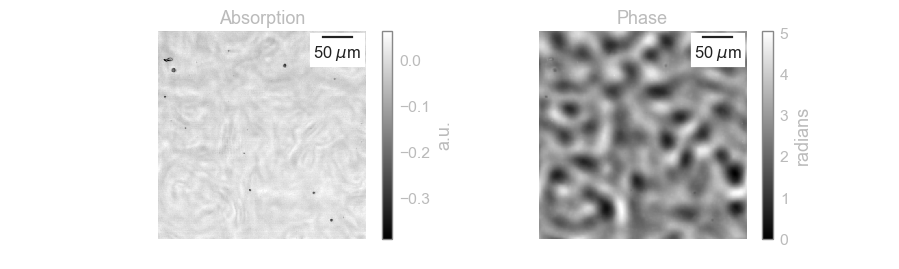

In [27]:
# Set reconstruction options
opts = dpc.DpcOptions()
opts.reg_u = 1e-10
opts.reg_p = 1e-10
opts.reg_TV = (5e-8, 2e-8)
opts.rho = 1e1
# opts.result_gaussian_filter_sigma = 30
opts.phase_offset_method = 'positive' # How to scale the phase
opts.roi = iotools.Roi(x_start=612, y_start=412, size=512)

# Generate Solver object
dpc_obj = dpc.DpcSolver(dataset=dpc_dataset, options=opts)

# Solve DPC reconstruction
result = dpc_obj.solve(algorithm='tv')

# Normalize results
dpc_obj.normalizeResult()

# Show results
dpc_obj.showResult()

# Show Sources

In [ ]:
plt.figure(figsize=(13,9))
for idx in range(4):
    plt.subplot(3, 4, idx + 1 )
    plt.imshow((np.abs(dpc_obj.source[idx]['r'])), interpolation='bilinear')
    plt.title('Source ' + str(idx) + ' (r)' + "(%d)" % np.sum(np.abs(dpc_obj.source[idx]['r'])))
    
    plt.subplot(3, 4, idx + 5 )
    plt.imshow((np.abs(dpc_obj.source[idx]['g'])), interpolation='bilinear')
    plt.title('Source ' + str(idx) + ' (g)' + "(%d)" % np.sum(np.abs(dpc_obj.source[idx]['g'])))
    
    plt.subplot(3, 4, idx + 9)
    plt.imshow((np.abs(dpc_obj.source[idx]['b'])), interpolation='bilinear')
    plt.title('Source ' + str(idx) + ' (b)' + "(%d)" % np.sum(np.abs(dpc_obj.source[idx]['b'])))


# Show Transfer Functions

In [ ]:
plt.figure(figsize=(11,6))
for idx in range(4):
    plt.subplot(240 + idx + 1 )
    plt.imshow(np.fft.fftshift(np.real(dpc_obj.Hp[idx])))
    plt.title('Hu ' + str(idx))
    plt.colorbar()
    
    plt.subplot(240 + idx + 1 + 4)
    plt.imshow(np.fft.fftshift(np.imag(dpc_obj.Hu[idx])))
    plt.title('Hp ' + str(idx))
    plt.colorbar()

## Save Object for Testing

In [ ]:
import scipy.io as sio

a = np.real(result[0]) * np.exp(1j * np.imag(result[0]))
res = {'object' : a, 
      'ps_um' : dpc_dataset.metadata.camera.pixel_size_um,
       'na' : dpc_dataset.metadata.objective.na,
       'mag' : dpc_dataset.metadata.objective.mag,
       'lambda' : 0.53
      }

sio.savemat('cells.mat', res)